In [1]:
## INSTALL THESE LIBRARES
# ! pip install tensorflow

In [2]:
TRAINING_SIZE=2500

In [3]:
import os
import sys
from IPython.display import Markdown, display
import re
from string import punctuation
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

    
def handle_helper_functions():
    print(sys.path)
    directory_path = os.path.abspath(os.path.join('../../helper'))
    if directory_path not in sys.path:
        sys.path.append(directory_path)    

    translation_path=os.path.abspath(os.path.join('../../utils')) 
    if translation_path not in sys.path:
        sys.path.append(translation_path)   
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/machine-learning/test/helper')                                       
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/machine-learning/utils')
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/machine-learning/data')


    lstm_helper_path = os.path.abspath(os.path.join('./create-model/lstm/'))
    if lstm_helper_path not in sys.path:
        sys.path.append(lstm_helper_path)    

    print(sys.path)
    

handle_helper_functions()

['/Users/learn/Desktop/Projects/machine-translation/machine-learning/train/lstm', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python39.zip', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9/lib-dynload', '', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9/site-packages']
['/Users/learn/Desktop/Projects/machine-translation/machine-learning/train/lstm', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python39.zip', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9/lib-dynload', '', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9/site-packages', '/Users/learn/Desktop/Projects/machine-translation/machine

In [4]:
from iit_dataset import createDataset


Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Reusing dataset parquet (/Users/learn/.cache/huggingface/datasets/parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
class Translator():
    def __init__(self, training_size=10000) -> None:
        self.model=None
        self.training_size=training_size
        self.idx_src=0
        self.idx_tar = 1
        self.source_str, self.target_str = "Hindi", "English"
        self.tar_tokenizer=None
        self.tar_vocab_size=None
        self.src_tokenizer=None
        self.tar_length=None
        self.src_vocab_size=None
        self.src_length=None
        self.trainX=None
        self.trainY=None
        self._convert_sentence_to_vectors()
        pass

    def train_model(self):
        ''' 
        GET TRAINING DATA FROM IIT DATASET
        TURN THEM INTO VECTORS
        CREATE ENCODER DICTIONARY 
        SAVE THEM INSIDE THE CLASS
        '''
        pass
    def _get_training_data(self):
        pool_oftexts, pairs =createDataset(data_size=self.training_size, type="train")
        dataset= pool_oftexts
        return dataset
    
    def clean(self,string):
        string = string.replace("\u202f"," ")
        string = string.lower()
        for p in punctuation + "«»" + "0123456789":
            string = string.replace(p," ")  
        string = re.sub('\s+',' ', string)
        string = string.strip()
            
        return string
    
    def _generate_train_test_split(self):
        ''' 
        GET TRAINING DATA AND SPLIT THEM TO TRAIN AND TEST SET

        RETURN dataset, train, test
        '''
        dataset= self._get_training_data()
        total_sentences= len(dataset)
        test_proportion = 0.1
        train_test_threshold = int( (1-test_proportion) * total_sentences)

        dataset["eng"] = dataset["eng"].apply(lambda x: self.clean(x))
        dataset["hindi"] = dataset["hindi"].apply(lambda x: self.clean(x))

        dataset = dataset.values
        dataset = dataset[:total_sentences]

        train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

        return dataset, train, test
    def create_tokenizer(self,lines):
        # fit a tokenizer
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(lines)
        return tokenizer
 

    def encode_sequences(self,tokenizer, length, lines):
        # encode and pad sequences
        X = tokenizer.texts_to_sequences(lines) # integer encode sequences
        X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
        return X
    
    def encode_output(self,sequences, vocab_size):
        # one hot encode target sequence
        ylist = list()
        for sequence in sequences:
            encoded = to_categorical(sequence, num_classes=vocab_size)
            ylist.append(encoded)
        y = np.array(ylist)
        y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
        return y
 

    def _convert_sentence_to_vectors(self):
        ''' 
        GENERATE TRAIN TEST SPLIT
        CREATE TARGET TOKENIZER
        CREATE SOURCE TOKENIZER
        RETURN VECTORS FOR TRAINING
        '''
        dataset, train, test= self. _generate_train_test_split()
        # Prepare target tokenizer
        tar_tokenizer = self.create_tokenizer(dataset[:, self.idx_tar]) #save
        tar_vocab_size = len(tar_tokenizer.word_index) + 1  #save
        tar_length = 15  #save
        printmd(f'\nTarget ({self.target_str}) Vocabulary Size: {tar_vocab_size}')
        printmd(f'Target ({self.target_str}) Max Length: {tar_length}')

        # Prepare source tokenizer
        src_tokenizer = self.create_tokenizer(dataset[:, self.idx_src])  #save
        src_vocab_size = len(src_tokenizer.word_index) + 1  #save
        src_length = 15  #save
        #### SAVE
        self.tar_tokenizer=tar_tokenizer
        self.tar_vocab_size=tar_vocab_size
        self.src_tokenizer=src_tokenizer
        self.tar_length=tar_length
        self.src_vocab_size=src_vocab_size
        self.src_length=src_length
        ### SAVE
        printmd(f'\nSource ({self.source_str}) Vocabulary Size: {src_vocab_size}')
        printmd(f'Source ({self.source_str}) Max Length: {src_length}\n')
        # PREPARING TRAINING DATA
        trainX = self.encode_sequences(src_tokenizer, src_length, train[:, self.idx_src])
        trainY = self.encode_sequences(tar_tokenizer, tar_length, train[:, self.idx_tar])
        trainY = self.encode_output(trainY, tar_vocab_size)
        self.trainX=trainX
        self.trainY=trainY
        pass
    
    def create_model(self, src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
        # Create the model
        model = Sequential()
        model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
        model.add(LSTM(n_units))
        model.add(RepeatVector(tar_timesteps))
        model.add(LSTM(n_units, return_sequences=True))
        model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
        return model
    
    def train(self):
        # Create model
        model=self.model
        model = self.create_model(self.src_vocab_size, self.tar_vocab_size, self.src_length, self.tar_length, 256)
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        #######################
        # display("TRAIN X: ",self.trainX)
        # display("TRAIN Y ",self.trainY)
        # display(model)
        #######################
        history = model.fit(self.trainX, 
               self.trainY, 
                epochs=1,#200 
                batch_size=64, 
                validation_split=0.1, 
                verbose=1,
                callbacks=[
                                EarlyStopping(
                                monitor='val_loss',
                                patience=10,
                                restore_best_weights=True
                            )
                    ])


        model.summary()
        # save model in computer '/Users/learn/Desktop/Projects/machine-translation/machine-learning/data'
        # model.save(filepath='../temp_model/')
        self.save_models_and_parameters(total_sentences=TRAINING_SIZE, model= model,src_tokenizer=self.src_tokenizer, tar_tokenizer=self.tar_tokenizer, src_length=self.src_length, tar_length=self.tar_length, src_vocab_size=self.src_vocab_size,tar_vocab_size=self.tar_vocab_size )
        pd.DataFrame(history.history).plot()
        plt.title("Loss")
        plt.show()
        pass

    def save_models_and_parameters( self, total_sentences ,model ,src_tokenizer , tar_tokenizer, src_length, tar_length, src_vocab_size,tar_vocab_size ):
        ''' 
        SAVE MODEL AND OTHER PARAMETERS IN DESIGNATED FOLDER
        '''
        model_name =str(total_sentences)
        # path="../../model/lstm/"+model_name+"/"
        path='../temp_model/'+model_name+"/"
        
        src_parameters={
            'src_length': src_length,
            'src_vocab_size': src_vocab_size,
        }
        src_tokenizer= src_tokenizer

        target_parameters={
            'target_length': tar_length,
            'target_vocab_size': tar_vocab_size,
        }
        target_tokenizer= tar_tokenizer

        model.save(path+'lstm_model' ) 
        with open(path+'src_parameters.pickle', 'wb') as handle:
            pickle.dump(src_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(path+'src_tokenizer.pickle', 'wb') as handle:
            pickle.dump(src_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(path+'target_parameters.pickle', 'wb') as handle:
            pickle.dump(target_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(path+'target_tokenizer.pickle', 'wb') as handle:
            pickle.dump(target_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        pass




In [6]:
translator= Translator(training_size=TRAINING_SIZE)


Target (English) Vocabulary Size: 742

Target (English) Max Length: 15


Source (Hindi) Vocabulary Size: 987

Source (Hindi) Max Length: 15


2023-08-03 19:02:54.915757: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-03 19:02:54.915801: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-03 19:02:54.915811: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-03 19:02:54.916195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-03 19:02:54.917095: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-08-03 19:02:57.975561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 19:02:58.593414: W te

32/32 [==============================] - ETA: 0s - loss: 3.0088

2023-08-03 19:03:09.031613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 19:03:09.336980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 19:03:09.506481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 14s 321ms/step - loss: 3.0088 - val_loss: 3.1557
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 256)           252672    
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 repeat_vector (RepeatVecto  (None, 15, 256)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 15, 256)           525312    
                                                                 
 time_distributed (TimeDist  (None, 15, 742)           190694    
 ributed)                                                        
                                

INFO:tensorflow:Assets written to: ../temp_model/2500/lstm_model/assets


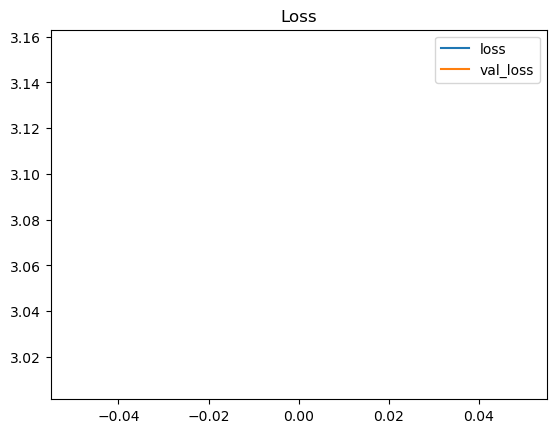

In [7]:
translator.train()

In [8]:
!jupyter kernelspec list


Available kernels:
  python3                /Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9/site-packages/ipykernel/resources
  machine-learning       /Users/learn/Library/Jupyter/kernels/machine-learning
  machine-translation    /Users/learn/Library/Jupyter/kernels/machine-translation
  scalis                 /Users/learn/Library/Jupyter/kernels/scalis
  threebie_ads           /Users/learn/Library/Jupyter/kernels/threebie_ads


In [9]:
! jupyter kernelspec uninstall silicon-kernel  -f 
! jupyter kernelspec list



Couldn't find kernel spec(s): silicon-kernel
Available kernels:
  python3                /Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9/site-packages/ipykernel/resources
  machine-learning       /Users/learn/Library/Jupyter/kernels/machine-learning
  machine-translation    /Users/learn/Library/Jupyter/kernels/machine-translation
  scalis                 /Users/learn/Library/Jupyter/kernels/scalis
  threebie_ads           /Users/learn/Library/Jupyter/kernels/threebie_ads
